In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Datasets
## Deliveries 
Wykorzystanie: Po złączeniu z danymi z products kiedy zamawiane jest najwięcej produktów (do tego celu potrzebujemy jeszcze danych z okresu październik - grudzień).

In [3]:
delivery_df = pd.read_json("./../data/raw/deliveries.jsonl", lines=True)
delivery_df.set_index('purchase_id', inplace=True)
delivery_df = delivery_df.replace([np.inf, -np.inf], np.nan)
delivery_df = delivery_df.dropna(subset=["delivery_company", 'delivery_timestamp'])
delivery_df['purchase_timestamp'] = pd.to_datetime(delivery_df['purchase_timestamp'])
delivery_df['delivery_timestamp'] = pd.to_datetime(delivery_df['delivery_timestamp'])
delivery_df['delivery_company'] = delivery_df["delivery_company"].astype(int)
delivery_df


,purchase_timestamp,delivery_timestamp,delivery_company
purchase_id,,,
20001,2021-01-06 22:50:03,2021-01-09 22:51:44,516
20002,2021-01-08 21:33:21,2021-01-13 21:35:21,360
20003,2021-01-07 23:48:32,2021-01-11 23:50:01,516
20004,2021-01-10 02:17:49,2021-01-15 02:20:55,360
20005,2021-01-06 08:05:00,2021-01-11 08:06:21,360
...,...,...,...
22776,2021-01-01 09:08:39,2021-01-04 09:13:34,360
22777,2021-01-03 00:04:24,2021-01-07 00:08:31,360
22778,2021-01-02 19:16:35,2021-01-04 19:20:08,360


## Products 
Wykorzystanie: możemy sprawdzać jakie kategorie produktów są najpopularniejsze - i w jakim czasie (łącząc ten dataset z deliveries) oraz do jakiej ceny. Przerobić kolumne category_path, join products z sessions i sprawdzić popularność po kategoriach, oraz częstość zakupów  
Pytanie: Przewidujemy potrzebe zakupu konkretnej rzeczy co kategoryzujemy?

In [4]:
product_df = pd.read_json("./../data/raw/products.jsonl", lines=True)
product_df.set_index('product_id', inplace=True)
product_df = product_df.replace([np.inf, -np.inf], np.nan)
product_df = product_df.dropna(subset=["price"])
product_df = product_df[product_df.price >= 0]
product_df

,product_name,category_path,price
product_id,,,
1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,5.897000e+01
1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2.048500e+03
1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01
1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01
1006,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,5.990000e+01
...,...,...,...
1315,Jabra Talk,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,5.499000e+01
1316,Plantronics Voyager Legend,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,2.490000e+02
1317,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,1.303960e+09


## Sessions 
Wykorzystanie: jakie produkty mają największe wzięcie, też jak często są wyświetlane   
Pytania: Jak zniżka wpływa na szybkie zniknięcie towaru z magazynu? Jeśli jest planowana, to ile więcej należy kupić rzeczy z danej kategorii? 

In [5]:
sessions_df = pd.read_json("./../data/raw/sessions.jsonl", lines=True)
sessions_df.set_index('session_id', inplace=True)
sessions_df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
session_id,,,,,,
100001,2021-01-10 16:32:24,102.0,1075.0,VIEW_PRODUCT,5,NaN
100001,2021-01-10 16:33:16,102.0,1079.0,VIEW_PRODUCT,5,NaN
100001,2021-01-10 16:37:18,102.0,1078.0,VIEW_PRODUCT,5,NaN
100001,2021-01-10 16:38:07,102.0,1077.0,VIEW_PRODUCT,5,NaN
100002,2021-01-06 22:28:51,102.0,1007.0,VIEW_PRODUCT,5,NaN
...,...,...,...,...,...,...
109153,2021-01-01 05:27:44,299.0,1017.0,VIEW_PRODUCT,20,NaN
109153,2021-01-01 05:31:55,299.0,1070.0,VIEW_PRODUCT,20,NaN
109153,2021-01-01 05:32:32,299.0,1034.0,VIEW_PRODUCT,20,NaN


## Users
Wykorzystanie: możemy spróbować znaleźć zależność jacy użytkownicy (skąd pochodzący) jakie produkty kupują, dzięki temu w zależności od aktywnych użytkowników w ostatnim czasie i ich miejsca zamieszkania możemy stwierdzić czego prawdopodobnie będą potrzebować.

In [6]:
users_df = pd.read_json("./../data/raw/users.jsonl", lines=True)
users_df

,user_id,name,city,street
0,102,Borys Klatka,Szczecin,plac Kolorowa 28/81
1,103,Adrian Zdancewicz,Poznań,ulica Jagiellońska 09
2,104,Albert Choina,Gdynia,ulica Jaworowa 11
3,105,Dagmara Dawidczyk,Kraków,ulica Asnyka 87/26
4,106,Stefan Łuszczyk,Warszawa,aleja Ludowa 98
...,...,...,...,...
195,297,Angelika Szoka,Radom,al. Sokola 282
196,298,Witold Sidorczuk,Wrocław,pl. Zacisze 62/54
197,299,Nicole Kryszczuk,Szczecin,aleja Żwirki i Wigury 63/58
198,300,Julita Białach,Kraków,ul. Rataja 866


# Wykresy danych

###  Ilość zamówień w danym miesiącu

<AxesSubplot:xlabel='purchase_timestamp'>

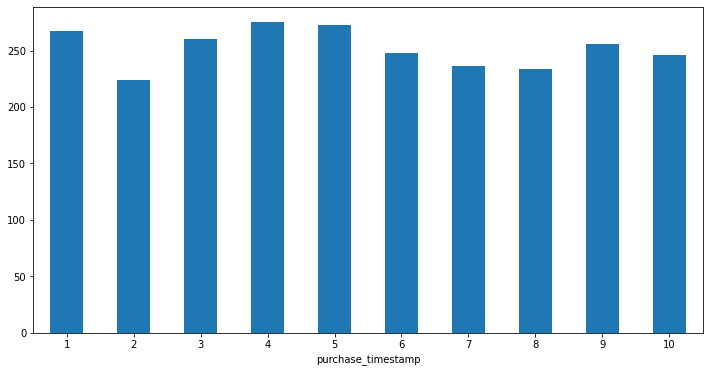

In [7]:
fig, axs = plt.subplots(figsize=(12, 6))
delivery_df.groupby(delivery_df["purchase_timestamp"].dt.month)["purchase_timestamp"].count().plot(kind='bar', rot=0, ax=axs)

In [8]:
# sprawdzenie 
delivery_df['year'] = pd.DatetimeIndex(delivery_df['purchase_timestamp']).year
delivery_df['month'] = pd.DatetimeIndex(delivery_df['purchase_timestamp']).month

sum = 0
for value in delivery_df['month'].values:
    if value == 1:
        sum += 1
print(sum)

267


###  Ilość zamówień z danej kategorii

In [9]:
purchase_from_category_df = pd.merge(sessions_df[sessions_df['event_type'] == "BUY_PRODUCT"], product_df, on='product_id', how='inner')
purchase_from_category_df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,2021-01-06 22:50:03,102.0,1314.0,BUY_PRODUCT,5,20001.0,Assassin&#39;s Creed (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
1,2021-03-03 08:05:34,261.0,1314.0,BUY_PRODUCT,0,20576.0,Assassin&#39;s Creed (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
2,2021-03-30 21:24:43,277.0,1314.0,BUY_PRODUCT,15,20857.0,Assassin&#39;s Creed (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
3,2021-04-04 11:24:51,284.0,1314.0,BUY_PRODUCT,5,20858.0,Assassin&#39;s Creed (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,2021-05-06 05:29:59,234.0,1314.0,BUY_PRODUCT,10,21196.0,Assassin&#39;s Creed (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
...,...,...,...,...,...,...,...,...,...
2428,2021-10-26 02:57:26,166.0,1156.0,BUY_PRODUCT,0,22734.0,Rig&#39;n&#39;Roll Tirowiec (PC),Gry i konsole;Gry komputerowe,4.99
2429,2021-08-24 07:41:52,142.0,1061.0,BUY_PRODUCT,5,22147.0,Warhammer 40.000 Dawn of War (PC),Gry i konsole;Gry komputerowe,10.99
2430,2021-10-03 07:52:02,263.0,1061.0,BUY_PRODUCT,20,22499.0,Warhammer 40.000 Dawn of War (PC),Gry i konsole;Gry komputerowe,10.99
2431,2021-09-06 02:37:42,212.0,1120.0,BUY_PRODUCT,0,22298.0,Civilization 4 Warlords (PC),Gry i konsole;Gry komputerowe,20.90


<AxesSubplot:xlabel='category_path'>

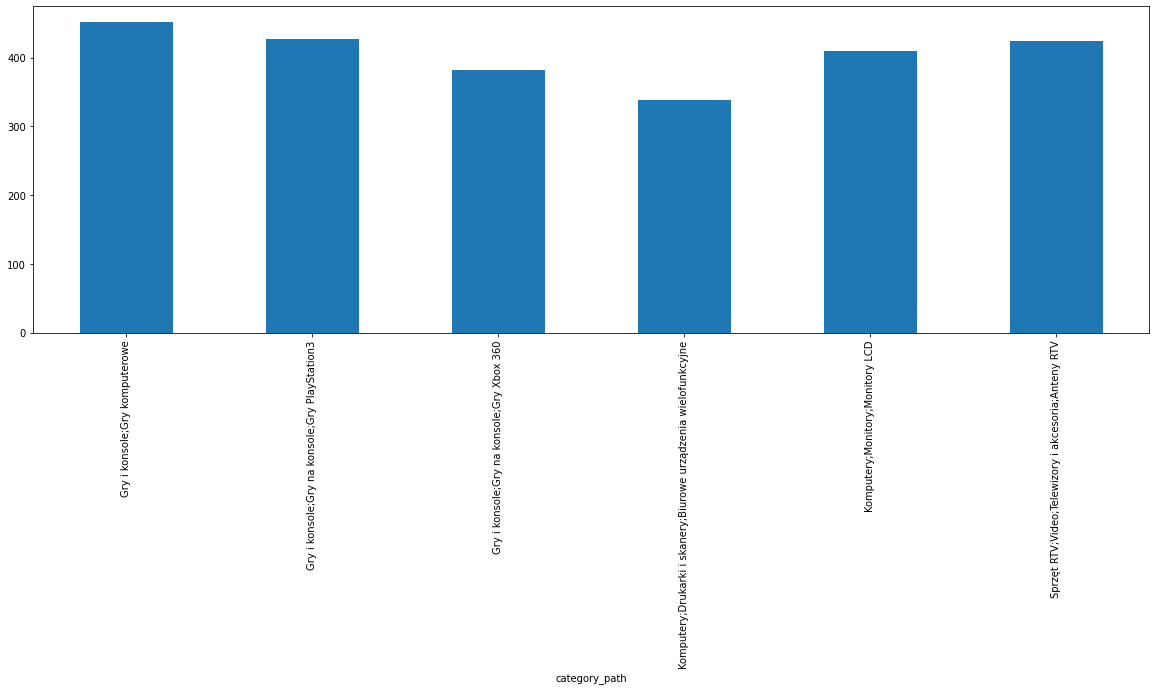

In [10]:
fig, axs = plt.subplots(figsize=(20, 6))
purchase_from_category_df.groupby(purchase_from_category_df["category_path"])["category_path"].count().plot(kind='bar', rot=90, ax=axs)

### Ilość zamówień w danych przedziałach cenowych

In [11]:
bought_product_df = sessions_df[sessions_df['event_type'] == "BUY_PRODUCT"]
bought_product_df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
session_id,,,,,,
100002,2021-01-06 22:50:03,102.0,1314.0,BUY_PRODUCT,5,20001.0
100005,2021-01-08 21:33:21,105.0,1143.0,BUY_PRODUCT,5,20002.0
100011,2021-01-07 23:48:32,110.0,1076.0,BUY_PRODUCT,0,20003.0
100013,2021-01-10 02:17:49,113.0,1128.0,BUY_PRODUCT,10,20004.0
100016,2021-01-06 08:05:00,115.0,1003.0,BUY_PRODUCT,15,20005.0
...,...,...,...,...,...,...
109131,2021-01-01 09:08:39,233.0,1005.0,BUY_PRODUCT,10,22776.0
109135,2021-01-03 00:04:24,241.0,1286.0,BUY_PRODUCT,15,22777.0
109138,2021-01-02 19:16:35,246.0,1023.0,BUY_PRODUCT,20,22778.0


In [12]:
df = pd.merge(bought_product_df, product_df, on='product_id', how='inner')
df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,2021-01-06 22:50:03,102.0,1314.0,BUY_PRODUCT,5,20001.0,Assassin&#39;s Creed (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
1,2021-03-03 08:05:34,261.0,1314.0,BUY_PRODUCT,0,20576.0,Assassin&#39;s Creed (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
2,2021-03-30 21:24:43,277.0,1314.0,BUY_PRODUCT,15,20857.0,Assassin&#39;s Creed (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
3,2021-04-04 11:24:51,284.0,1314.0,BUY_PRODUCT,5,20858.0,Assassin&#39;s Creed (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,2021-05-06 05:29:59,234.0,1314.0,BUY_PRODUCT,10,21196.0,Assassin&#39;s Creed (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
...,...,...,...,...,...,...,...,...,...
2428,2021-10-26 02:57:26,166.0,1156.0,BUY_PRODUCT,0,22734.0,Rig&#39;n&#39;Roll Tirowiec (PC),Gry i konsole;Gry komputerowe,4.99
2429,2021-08-24 07:41:52,142.0,1061.0,BUY_PRODUCT,5,22147.0,Warhammer 40.000 Dawn of War (PC),Gry i konsole;Gry komputerowe,10.99
2430,2021-10-03 07:52:02,263.0,1061.0,BUY_PRODUCT,20,22499.0,Warhammer 40.000 Dawn of War (PC),Gry i konsole;Gry komputerowe,10.99
2431,2021-09-06 02:37:42,212.0,1120.0,BUY_PRODUCT,0,22298.0,Civilization 4 Warlords (PC),Gry i konsole;Gry komputerowe,20.90


<AxesSubplot:xlabel='price'>

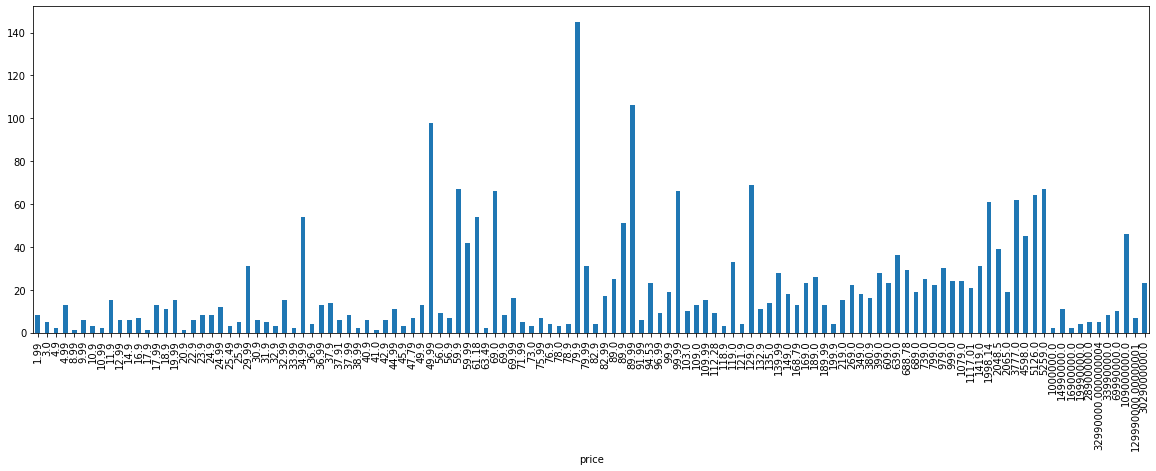

In [13]:
fig, axs = plt.subplots(figsize=(20, 6))
df.groupby(df["price"])["price"].count().plot(kind='bar', rot=90, ax=axs) # do skonsultowania jak chcemy grupować

In [14]:
user_activity = sessions_df[["event_type", "timestamp"]].copy()
user_activity["month"] = pd.DatetimeIndex(user_activity["timestamp"]).month
user_activity["day"] = pd.DatetimeIndex(user_activity["timestamp"]).day
user_activity["date"] = pd.DatetimeIndex(user_activity["timestamp"]).date

user_activity

,event_type,timestamp,month,day,date
session_id,,,,,
100001,VIEW_PRODUCT,2021-01-10 16:32:24,1,10,2021-01-10
100001,VIEW_PRODUCT,2021-01-10 16:33:16,1,10,2021-01-10
100001,VIEW_PRODUCT,2021-01-10 16:37:18,1,10,2021-01-10
100001,VIEW_PRODUCT,2021-01-10 16:38:07,1,10,2021-01-10
100002,VIEW_PRODUCT,2021-01-06 22:28:51,1,6,2021-01-06
...,...,...,...,...,...
109153,VIEW_PRODUCT,2021-01-01 05:27:44,1,1,2021-01-01
109153,VIEW_PRODUCT,2021-01-01 05:31:55,1,1,2021-01-01
109153,VIEW_PRODUCT,2021-01-01 05:32:32,1,1,2021-01-01


<AxesSubplot:xlabel='month'>

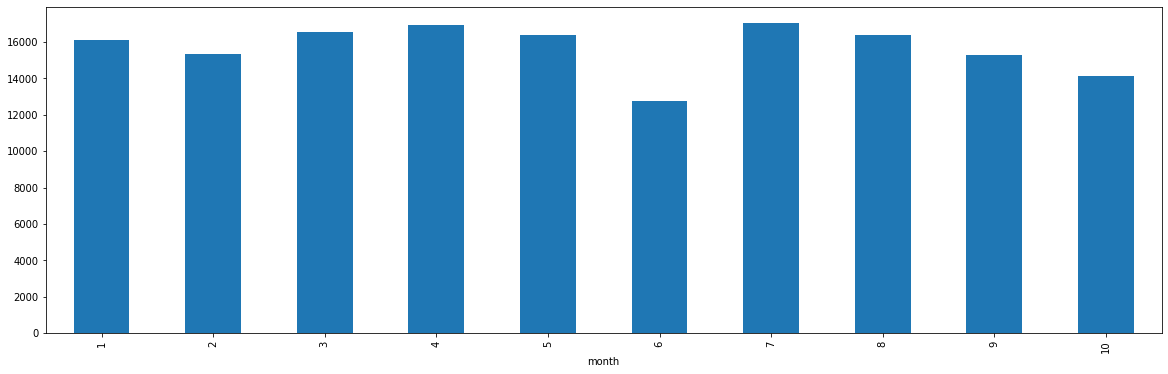

In [15]:
fig, axs = plt.subplots(figsize=(20, 6))
user_activity.groupby(user_activity["month"])["month"].count().plot(kind='bar', ax=axs) 

<AxesSubplot:xlabel='day'>

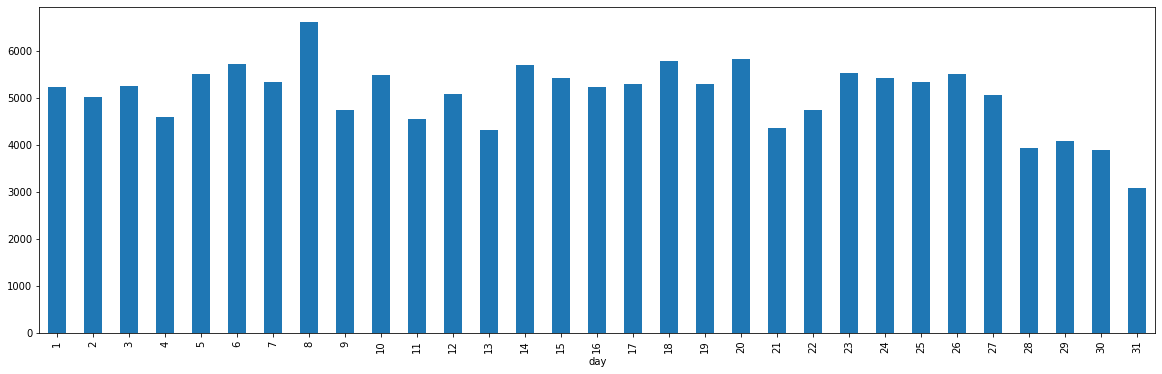

In [16]:
fig, axs = plt.subplots(figsize=(20, 6))
user_activity.groupby(user_activity["day"])["day"].count().plot(kind='bar', ax=axs) 

<AxesSubplot:xlabel='date'>

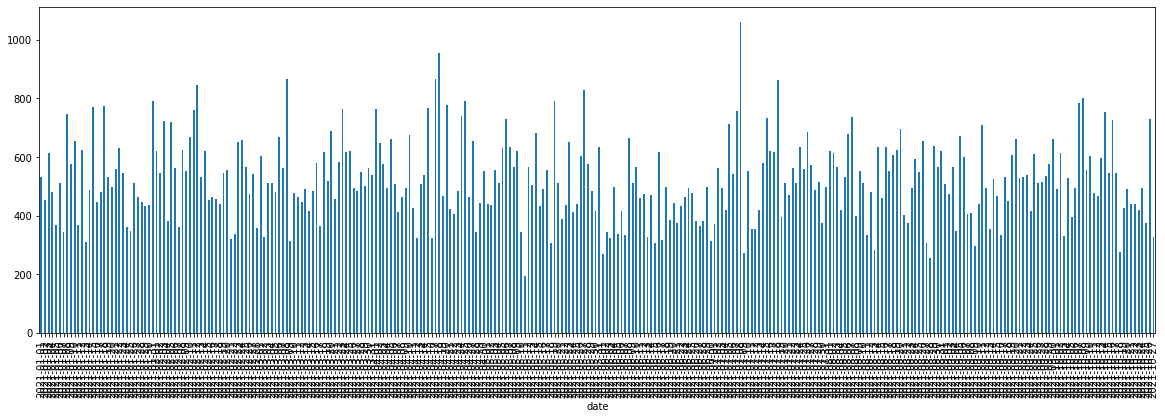

In [17]:
fig, axs = plt.subplots(figsize=(20, 6))
user_activity.groupby(user_activity["date"])["date"].count().plot(kind='bar', ax=axs) 

<AxesSubplot:xlabel='offered_discount'>

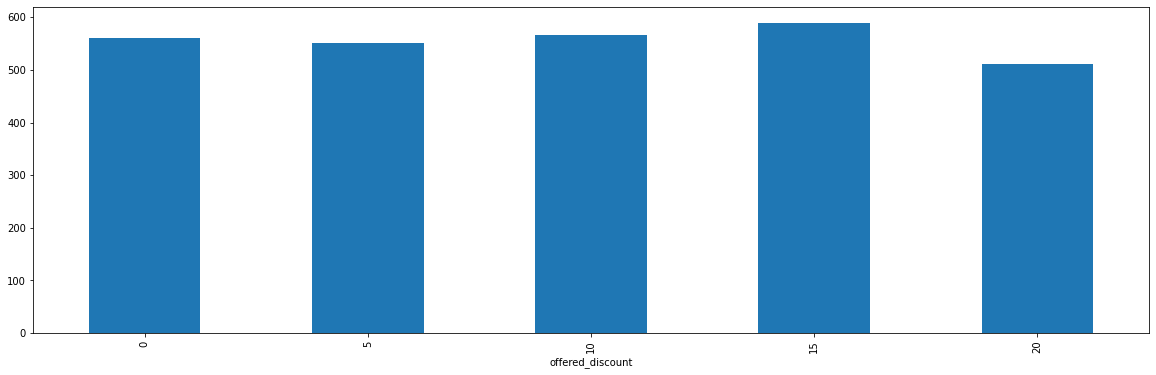

In [18]:
fig, axs = plt.subplots(figsize=(20, 6))
bought_product_df.groupby(bought_product_df["offered_discount"])["offered_discount"].count().plot(kind='bar', ax=axs) 

In [19]:
sessions_df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
session_id,,,,,,
100001,2021-01-10 16:32:24,102.0,1075.0,VIEW_PRODUCT,5,NaN
100001,2021-01-10 16:33:16,102.0,1079.0,VIEW_PRODUCT,5,NaN
100001,2021-01-10 16:37:18,102.0,1078.0,VIEW_PRODUCT,5,NaN
100001,2021-01-10 16:38:07,102.0,1077.0,VIEW_PRODUCT,5,NaN
100002,2021-01-06 22:28:51,102.0,1007.0,VIEW_PRODUCT,5,NaN
...,...,...,...,...,...,...
109153,2021-01-01 05:27:44,299.0,1017.0,VIEW_PRODUCT,20,NaN
109153,2021-01-01 05:31:55,299.0,1070.0,VIEW_PRODUCT,20,NaN
109153,2021-01-01 05:32:32,299.0,1034.0,VIEW_PRODUCT,20,NaN


In [40]:
df = pd.merge(sessions_df, product_df, on='product_id', how='inner')

<AxesSubplot:xlabel='category_path'>

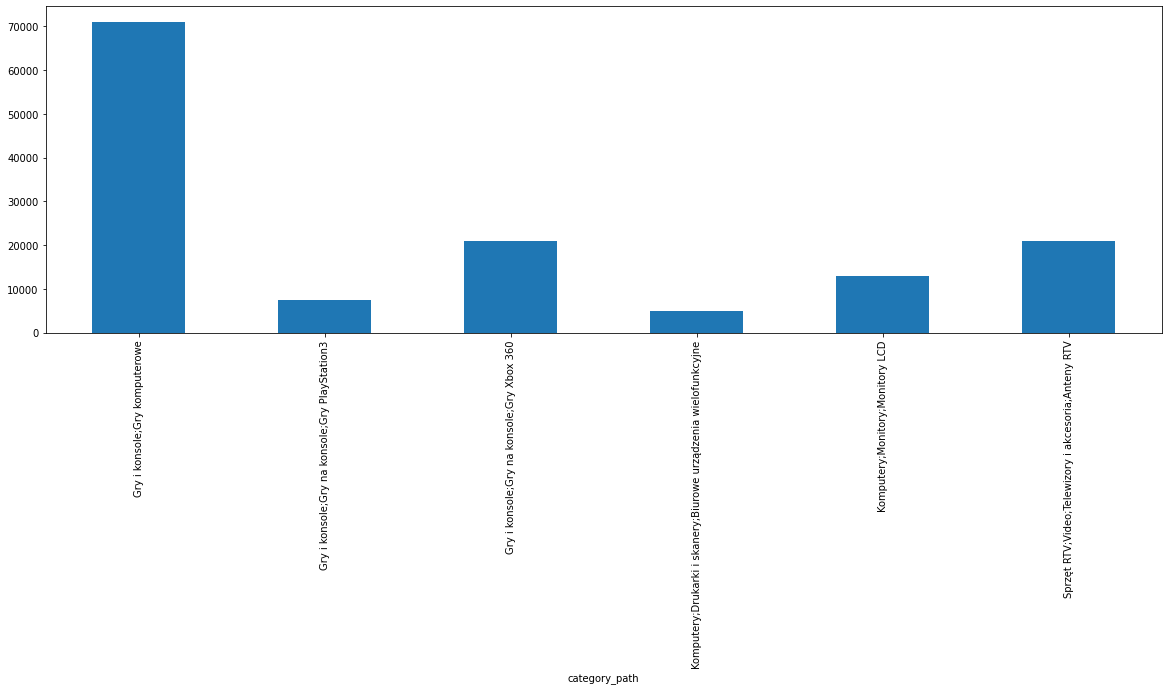

In [48]:
fig, axs = plt.subplots(figsize=(20, 6))
df[df["event_type"] == "VIEW_PRODUCT"].groupby('category_path')["category_path"].count().plot(kind='bar', ax=axs) 


<AxesSubplot:xlabel='category_path'>

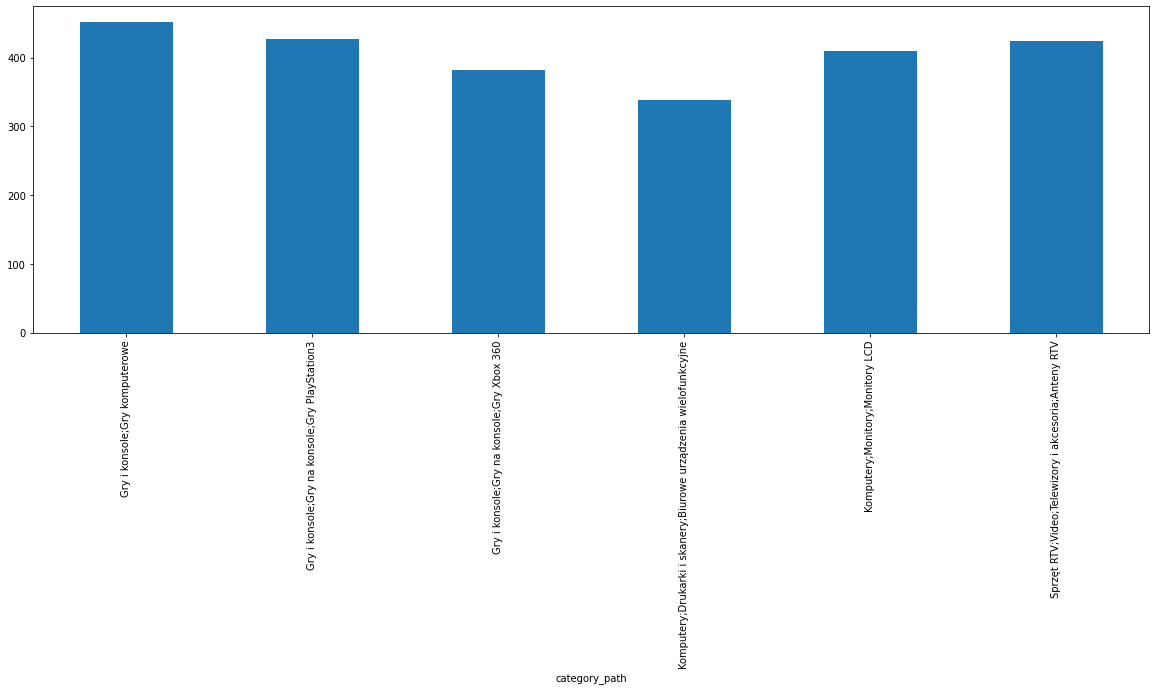

In [49]:
fig, axs = plt.subplots(figsize=(20, 6))
df[df["event_type"] == "BUY_PRODUCT"].groupby('category_path')["category_path"].count().plot(kind='bar', ax=axs) 